In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Tensorflow version: 2.4.1
GPU detected: []
/kaggle/input/entity-annotated-corpus/ner.csv
/kaggle/input/entity-annotated-corpus/ner_dataset.csv
/kaggle/input/bert-base-uncased/config.json
/kaggle/input/bert-base-uncased/pytorch_model.bin
/kaggle/input/bert-base-uncased/vocab.txt


In [2]:
data = pd.read_csv('/kaggle/input/entity-annotated-corpus/ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [4]:
print("unique words; ",data["Word"].nunique())
print("unique tags; ",data["Tag"].nunique())

unique words;  35178
unique tags;  17


In [5]:
#creating dataset for unique words, tags
words = list(set(data["Word"].values))
words.append("ENDPAD")
tags = list(set(data["Tag"].values))

In [6]:
np.shape(words)

(35179,)

In [7]:
num_words = len(words)
num_tags = len(tags)

In [8]:
class Sentence_getter(object):
    def __init__(self, data):
        self.data = data
        agg_fun = lambda s: [(w, p, t) for w,p,t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s['Tag'].values.tolist())]
        
        self.grouped = self.data.groupby('Sentence #').apply(agg_fun)
        self.sentences = [i for i in self.grouped]
    
    

In [9]:
getter = Sentence_getter(data)

In [10]:
sentences = getter.sentences

In [11]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [12]:
# Creating vocabulary
word2idx = {w: i+1 for i,w in enumerate(words)}
tag2idx = {t: i for i,t in enumerate(tags)}

In [13]:
tag2idx

{'B-geo': 0,
 'B-gpe': 1,
 'I-geo': 2,
 'B-per': 3,
 'I-gpe': 4,
 'I-tim': 5,
 'I-eve': 6,
 'I-nat': 7,
 'O': 8,
 'B-nat': 9,
 'B-eve': 10,
 'B-art': 11,
 'B-org': 12,
 'I-org': 13,
 'I-per': 14,
 'I-art': 15,
 'B-tim': 16}

**Hist plot of len of sentences**

[]

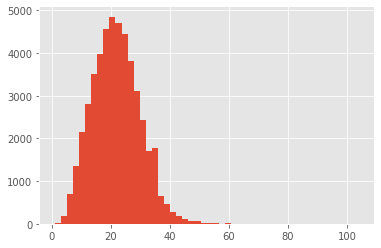

In [14]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.plot()

Lets take 50 as maxlen to be on safer side

Padding inputs to maxlen

Creating INPUTS AND OUTPUTS

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen = max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen = max_len, sequences=y, padding='post', value=tag2idx["O"])


Converting output labels to categorical ( ONE_HOT )

In [16]:
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [17]:
y[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0

Now train-test splitting

In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=1 )

Building and compiling a BiLSTM

In [19]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [20]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)

model = Model(input_word, out)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            3417      
Total params: 1,883,167
Trainable params: 1,883,167
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

TRAINING MODEL with per-epoch visualizations using CALLBACKS

In [22]:
pip install livelossplot

Note: you may need to restart the kernel to use updated packages.


In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot import PlotLossesKeras


In [24]:
type(y_train)

list

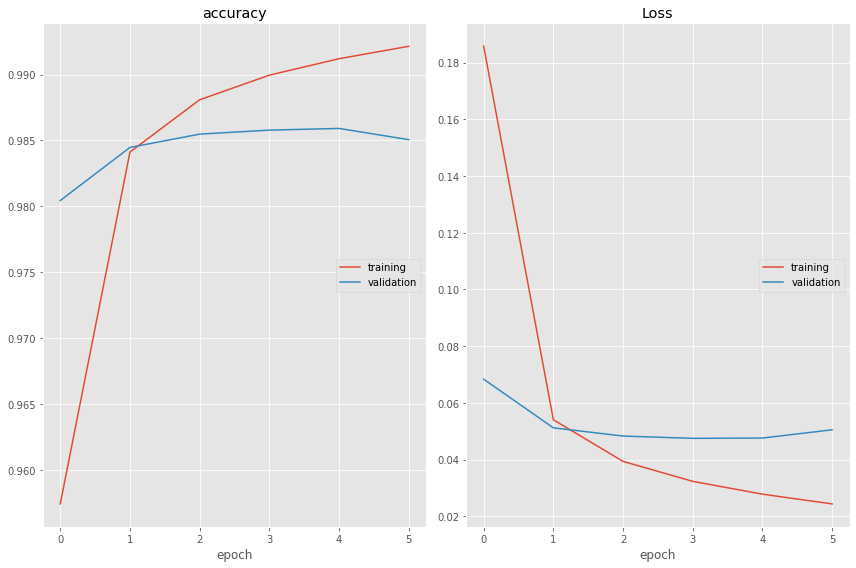

accuracy
	training         	 (min:    0.957, max:    0.992, cur:    0.992)
	validation       	 (min:    0.980, max:    0.986, cur:    0.985)
Loss
	training         	 (min:    0.024, max:    0.186, cur:    0.024)
	validation       	 (min:    0.047, max:    0.068, cur:    0.051)


In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesKeras(), early_stopping]

history = model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    verbose=100,
    callbacks=callbacks
)

In [26]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 3s 20ms/step - loss: 0.0514 - accuracy: 0.9853


[0.05143486708402634, 0.9852710366249084]

In [27]:
x_test[0]

array([13232,   590, 24774,  3123,   364, 30127, 24774,  9400,   354,
       14852,  9763,  4042,   354, 21106, 24103,  5264,  6725,  5742,
       24774,  6725, 13074, 14864, 28851,  6045,  9085, 18636,   354,
       13218,  9505, 25015,  7808, 14864,  6725, 30677, 13225, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [28]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
# print(np.shape(p))
# print(p)
p = np.argmax(p, axis=-1)


y_true = np.argmax(np.array(y_test), axis=-1)[i]

print("{:15}{:5}\t{}\n".format("Word", "True", "Pred"))
print("-"*30)

for (w, t, pred) in zip(x_test[i], y_true, p[0]):
    print("{:15}{}\t{}".format(words[w-1], tags[t], tags[pred]))

Word           True 	Pred

------------------------------
The            O	O
United         B-org	B-org
Nations        I-org	I-org
has            O	O
been           O	O
under          O	O
fire           O	O
for            O	O
failing        O	O
to             O	O
stop           O	O
ongoing        O	O
ethnic         O	O
violence       O	O
in             O	O
Ituri          B-geo	B-geo
.              O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso          O	O
Couso 